# Transfer Learning on Kidney Stone Images
This notebook contains the code used for analyzing kidney stone images with the ultimate goal of classifying six different types of stones. We applied a transfer learning approach using the ResNet 50 architecture and ImageNet weights on a clinical dataset. Initially, the model is trained to distinguish between kidney stones in dataset 1. Subsequently, it will be retrained to categorize renal calculi from dataset 2.
<br>You can read more about the methodology and results in: https://arxiv.org/abs/2210.13654

## Before starting, keep some things in consideration
* You should have the images in a Google Drive folder organized as follows:

  * `main_folder/view/kind_dataset/images`
  
  Where:
    - `main_folder` is the place where you will store all the data.
    - `view` could be the folder with data from Section, Surface, or Mix.
    - `kind_dataset` could be Train, Validation, or Test.
    - `images` contains patches with the image data.


## Import the path of the different datasets

The variables are explained here:  
- `dataset_n_train` is the place where you stored the training data of the dataset
- `dataset_n_test`  is the place where you stored the testing data of the dataset
- `save_model_n_TL` is the path where you want to save the trained model (take care to set the **.pth** at the end of the filename)
- `metrics_test_n_TL` will store the main metrics of the evaluated model (take care to set the **.csv** at the end of the filename)


In [ ]:
dataset_1_train = "/content/drive/MyDrive/Dataset/Michel Daudon/Michel Daudon (6 classes - w256 -1k)/SEC/train"
dataset_1_test = "/content/drive/MyDrive/Dataset/Michel Daudon/Michel Daudon (6 classes - w256 -1k)/SEC/test"
save_model_1_TL = "/content/drive/MyDrive/Proyecto Calculos Renales/Models_new/SEC/model_sec_res_md_2.pth"
metrics_test_1_TL = "/content/drive/MyDrive/Proyecto Calculos Renales/Models_new/SEC/model_sec_res_md_2.csv"


dataset_2_train = "/content/drive/MyDrive/Dataset/Jonathan El-Beze/Jonathan El-Beze (6 classes - w256 - 1k)/SEC/train"
dataset_2_test = "/content/drive/MyDrive/Dataset/Jonathan El-Beze/Jonathan El-Beze (6 classes - w256 - 1k)/SEC/test"
save_model_2_TL = "/content/drive/MyDrive/Proyecto Calculos Renales/Models_new/SEC/model_sec_res_md_TL_jeb_2.pth"
metrics_test_2_TL = "/content/drive/MyDrive/Proyecto Calculos Renales/Models_new/SEC/model_sec_res_md_TL_jeb_2.csv"

## Connecting with google drive

In [ ]:
#Connect with drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Check if the notebook is connected to a GPU environment

In [ ]:
#GPU info for colab notebook
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 13 09:01:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0              28W /  70W |    337MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import all the necessary libraries

In [ ]:
import os
import time
import copy
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights,ResNet101_Weights
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
cudnn.benchmark = True #PyTorch will attempt to find the best algorithms for the hardware at runtime.
plt.ion()   # interactive mode

### Fixing some parameters for reproducibility

In [ ]:
MANUAL_SEED = 3407
G = torch.Generator()
G.manual_seed(MANUAL_SEED)
np.random.seed(3407)
random.seed(3407)

## Creating dataset for first step

In [ ]:
def split_dataset(datasets,split_proportion,to_split = 'train'):

    '''
    Function that splits any dataset into a principal subset and a smaller subset
    based on a split proportion.
    Parameters
    ----------
    datasets : dict
        dictionary containing the dataset to split.
    to_split : str
        string representing the key of the dataset to split contained in datasets. Default: 'train'
    split_proportion: float
        float between 0-1 that represents the proportion of the main dataset that will be
        the new splitted one.
    Returns
    -------
    tuple
        (main subset, splitted subset)
    '''

    main_indices, subset_indices = train_test_split(list(range(len(datasets[to_split].targets))), test_size=split_proportion,
                                                  stratify=datasets[to_split].targets)

    main_split = torch.utils.data.Subset(datasets[to_split], main_indices)
    subset_split = torch.utils.data.Subset(datasets[to_split], subset_indices)

    return main_split,subset_split


#Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #these stats are from imagenet
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #these stats are from imagenet
    ]),
}


# Directories of your train and test dataset
data_dir_train = dataset_1_train
data_dir_test = dataset_1_test

#Create datasets from the paths
image_datasets = {'train': datasets.ImageFolder(data_dir_train, data_transforms['train']),
                      'test': datasets.ImageFolder(data_dir_test, data_transforms['test'])
                      }

class_names = image_datasets['train'].classes

#Split the train dataset loaded before into train and valid datasets (90 training, 10 validation)
image_datasets['train'], image_datasets['valid'] = split_dataset(image_datasets,0.1,'train')

#Dejar ese mismo batchsize?
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= 24,
                                                  shuffle=True, generator=G) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid','test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize images from a batch



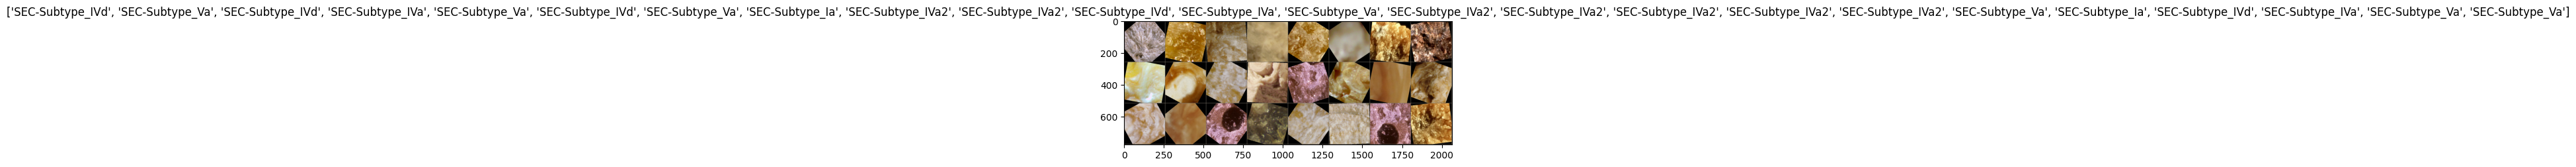

In [ ]:
# Visualize the images of a batch and its label
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5, FILE = None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_incorrects=0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_incorrects += torch.sum(preds!=labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) #copy of the values from the model for future epochs
                best_model_m = model #Model to be saved after all the training process

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_acc:4f}')

    #Directory where you want to save your model as a .pth file
    torch.save(best_model_m,FILE)
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualize model predictions

Generic function to display predictions for a few images


In [ ]:
# Visualizing the model predictions
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds)
            print(labels)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                ax.set_xlabel(labels[j])
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# First Step Transfer Learning
This step works based on a pretrained resnet 50, so this would be the first step, like:  <br> **resnet50 -> MD** <br>

In [ ]:
#load the resnet50 model with pre-trained weights
model_ft = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

#add some new layers
model_ft.fc=  nn.Sequential(

   nn.Flatten(),
   nn.Linear(num_ftrs,768),
   nn.BatchNorm1d(768),
   nn.ReLU(),
   nn.Dropout(),

   nn.Linear(768,256),
   nn.BatchNorm1d(256),
   nn.ReLU(),
   nn.Dropout(),

   nn.Linear(256,128),
   nn.BatchNorm1d(128),
   nn.ReLU(),
   nn.Dropout(),

   nn.Linear(128,6) #change the 6 according to the number of outputs that you have

)
model_ft=model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# This scheduler will adjust the learning rate since it is a hyperparameter
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.1MB/s]


## Model architecture

In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Training the model

In [ ]:
model_sec_res_md_jeb  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=30, FILE = save_model_1_TL)

Epoch 0/29
----------
train Loss: 1.4727 Acc: 0.4340
valid Loss: 0.8375 Acc: 0.7708

Epoch 1/29
----------
train Loss: 0.7670 Acc: 0.7630
valid Loss: 0.3384 Acc: 0.9417

Epoch 2/29
----------
train Loss: 0.4558 Acc: 0.8752
valid Loss: 0.1806 Acc: 0.9562

Epoch 3/29
----------
train Loss: 0.3187 Acc: 0.9130
valid Loss: 0.0892 Acc: 0.9833

Epoch 4/29
----------
train Loss: 0.2633 Acc: 0.9313
valid Loss: 0.0699 Acc: 0.9833

Epoch 5/29
----------
train Loss: 0.1890 Acc: 0.9514
valid Loss: 0.0573 Acc: 0.9812

Epoch 6/29
----------
train Loss: 0.1676 Acc: 0.9583
valid Loss: 0.0423 Acc: 0.9875

Epoch 7/29
----------
train Loss: 0.1703 Acc: 0.9553
valid Loss: 0.0310 Acc: 0.9917

Epoch 8/29
----------
train Loss: 0.1519 Acc: 0.9630
valid Loss: 0.0287 Acc: 0.9938

Epoch 9/29
----------
train Loss: 0.1523 Acc: 0.9590
valid Loss: 0.0315 Acc: 0.9917

Epoch 10/29
----------
train Loss: 0.1364 Acc: 0.9662
valid Loss: 0.0233 Acc: 0.9958

Epoch 11/29
----------
train Loss: 0.1231 Acc: 0.9701
valid Loss

#Evaluate the model

In [ ]:
model_name = save_model_1_TL #path where you saved the trained model
model_conv = torch.load(model_name)
model_conv.eval()

#Deactivate gradient calculations for inference
with torch.no_grad():
  for i, (X_test, y) in enumerate(dataloaders['test']):
    X_test = X_test.to(device)

    logits = model_conv(X_test)

    pred = np.argmax(F.softmax(logits.cpu(), dim=1), 1)

    if i == 0:
      y_pred = pred
      y_test = y

    else:
      y_pred = np.hstack((y_pred, pred))
      y_test = np.hstack((y_test, y))


report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

df_report = pd.DataFrame(report).transpose()

#path to save the metrics in a csv file
output_name = metrics_test_1_TL

df_report.to_csv(output_name)

In [ ]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#Second Step Transfer Learning

## Upload second dataset information

In [ ]:
# Directories of your train and test dataset
data_dir_train_2 = dataset_2_train
data_dir_test_2 = dataset_2_test

#Create datasets from the directions
image_datasets_2 = {'train': datasets.ImageFolder(data_dir_train_2, data_transforms['train']), #Same transformations as dataset 1
                      'test': datasets.ImageFolder(data_dir_test_2, data_transforms['test'])
                      }

class_names_2 = image_datasets_2['train'].classes

#Split the train dataset loaded before into train and valid datasets (90 training, 10 validation)
image_datasets_2['train'], image_datasets_2['valid'] = split_dataset(image_datasets_2,0.1,'train')

dataloaders_2 = {x: torch.utils.data.DataLoader(image_datasets_2[x], batch_size= 24,
                                                  shuffle=True, generator=G) for x in ['train', 'valid', 'test']}

dataset_sizes_2 = {x: len(image_datasets_2[x]) for x in ['train', 'valid','test']}

#Run this line if you have to connect the device again
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load pre-trained model

In [ ]:
model_pre = torch.load(save_model_1_TL)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_pre.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Fine-tune pre-trained model with a new dataset

In [ ]:
second_model = train_model(model_pre, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=30, FILE = save_model_2_TL)

Epoch 0/29
----------
train Loss: 0.5512 Acc: 0.8333
valid Loss: 0.2173 Acc: 0.9292

Epoch 1/29
----------
train Loss: 0.3647 Acc: 0.8958
valid Loss: 0.2153 Acc: 0.9313

Epoch 2/29
----------
train Loss: 0.2266 Acc: 0.9352
valid Loss: 0.0815 Acc: 0.9750

Epoch 3/29
----------
train Loss: 0.2169 Acc: 0.9361
valid Loss: 0.0694 Acc: 0.9792

Epoch 4/29
----------
train Loss: 0.1436 Acc: 0.9597
valid Loss: 0.0704 Acc: 0.9750

Epoch 5/29
----------
train Loss: 0.1279 Acc: 0.9632
valid Loss: 0.0595 Acc: 0.9792

Epoch 6/29
----------
train Loss: 0.1115 Acc: 0.9697
valid Loss: 0.0451 Acc: 0.9875

Epoch 7/29
----------
train Loss: 0.0607 Acc: 0.9822
valid Loss: 0.0270 Acc: 0.9917

Epoch 8/29
----------
train Loss: 0.0502 Acc: 0.9866
valid Loss: 0.0193 Acc: 0.9958

Epoch 9/29
----------
train Loss: 0.0415 Acc: 0.9896
valid Loss: 0.0168 Acc: 0.9958

Epoch 10/29
----------
train Loss: 0.0457 Acc: 0.9868
valid Loss: 0.0229 Acc: 0.9958

Epoch 11/29
----------
train Loss: 0.0355 Acc: 0.9938
valid Loss

# Evaluation Second Phase Transfer Learning

In [ ]:
model_name = save_model_2_TL

model_conv = torch.load(model_name)
model_conv.eval()

#Deactivate gradient calculations for inference
with torch.no_grad():
  for i, (X_test, y) in enumerate(dataloaders['test']):
    X_test = X_test.to(device)

    logits = model_conv(X_test)

    pred = np.argmax(F.softmax(logits.cpu(), dim=1), 1)

    if i == 0:
      y_pred = pred
      y_test = y

    else:
      y_pred = np.hstack((y_pred, pred))
      y_test = np.hstack((y_test, y))


report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

df_report = pd.DataFrame(report).transpose()

output_name = metrics_test_2_TL

df_report.to_csv(output_name)